<div style="font-size:18pt;padding-top:20px; text-align:center">Домашнее задание 2. <b>Модели предсказания</b> </div><hr>
<div style="text-align:right;">Куценко А. А <span style="font-style: italic;font-weight: bold;">(ftruf357ft@gmail.com)</span></div>

Подключение стилей оформления

In [1]:
%%html
<link href="css/style.css" rel="stylesheet" type="text/css">

### Содержание

- [Вариант](#Вариант)
- [Задача 1. Реализация собственных классов и функций (4 балла)](#Задача-1.-Реализация-собственных-классов-и-функций-(4-балла))

# Цель работы
Приобрести опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.

При выполнении работы решаются следующие задачи:
- реализация собственных классов, совместимых с библиотекой `sklearn`;
- оценка влияния регуляризации в моделях предсказания;
- преобразование исходных данных посредством транформаторов `sklearn`;
- использование отложенной выборки и кросс-валидации;
- выбор гиперпараметров и интерпретация кривых обучения;
- оценка качества моделей предсказания;
- выявление преимуществ и недостатков методов предсказания в зависимости от поставленной задачи.

# Вариант

In [2]:
surname = "Куценко"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 55,  1, 44, 26, 18, 3, 38, 26, 18, 12,  3, 49, 45,
        7, 42, 9,  4,  3, 36, 33, 31, 29,  5, 4,  4, 19, 21, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 40 + 1

print("Задание № 2. Вариант: ", variant % 2 + 1)
print("Задание № 3. Вариант: ", variant % 3 + 1 )

Задание № 2. Вариант:  2
Задание № 3. Вариант:  3


## Задача 1. Реализация собственных классов и функций (4 балла)

### Условие

> **Замечание**. 1) Нельзя пользоваться готовыми реализациями `sklearn`; 2) чтобы избежать случая с вырожденной матрицей при оценке параметров добавьте незначительную регуляризацию по умолчанию или используйте `lstsq` из пакета `numpy` или др. способ; 3) используйте `random_state=0`

1. Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с `sklearn`. Передаваемые параметры: 1) коэффициент регуляризации (`alpha`). Использовать метод наименьших квадратов с регуляризацией;

2. Реализуйте класс для стандартизации признаков в виде трансформации, совместимый с `sklearn`. Передаваемые параметры: 1) `has_bias` (содержит ли матрица вектор единиц), 2) `apply_mean` (производить ли центровку)

3. Реализуйте функции для расчета $MSE$ и $R^2$ при отложенной выборке (`run_holdout`) и кросс-валидации (`run_cross_val`). Для кросс-валидации используйте **только** класс `KFold`. Выходными значениями должны быть $MSE$ и $R^2$ для обучающей и тестовой частей.

Шаблон кода:
```python
def run_holdout(model, X, y, train_size, random_state) -> dict:
    ...
    return scores


def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:
    ...
    return scores
```

4. Используя класс `Pipeline`, выполнить обучение линейной регрессии с предварительной стандартизацией с коэффициентом регуляризации равным `0` и `0.01`. Выведите значения параметров обученной модели. Выведите значения $MSE$ и $R^2$, полученные посредством функций `run_holdout` и `run_cross_val`. Отобразите график предсказание ($\hat{y}$) - действительное значение ($y$) для разных коэффициентов регуляризации для обучающего и текстового множества. Использовать следующие параметры:
    - `train_size=0.75`,
    - `n_splits=4`,
    - `shuffle=True`,
    - `random_state=0`
  
> **Замечание**: при формировании исходных данных использовался полином 16 степени одномерных данных.


### Выполнение

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

1. Нужно реализовать класс линейной регрессии с регуляризацией и использованием метода МНК. Поскольку реализуемый класс - это estimator, то нужно отнаследоваться от `BaseEstimator`, а также отнаследоваться от базового для всех регрессоров класса `RegressorMixin`

Поскольку в задании не указан тип, будем использовать L2 регуляризацию

In [4]:
class CustomRidge(BaseEstimator, RegressorMixin):
    epsilon = 10e-10
    
    def __init__(self, alpha=10e-4):
        self.alpha = alpha

        # Избегаем сингулярной матрицы, если коэффициент регуляризации близок или равен нулю
        if self.alpha < self.epsilon:
            self.alpha = self.epsilon

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_in_ = X.shape[1]

        X_ = np.c_[np.ones(X.shape[0]), X]
        
        E = np.eye(X_.shape[1])

        # не осуществляем регуляризацию для свободного параметра coef_[0]
        E[0, 0] = 0
        self.coef_ = np.linalg.inv(X_.T @ X_ + self.alpha * E) @ X_.T @ y
        return self

    def predict(self, X):
        check_is_fitted(self, 'coef_')
        X = check_array(X)
        X_ = np.c_[np.ones(X.shape[0]), X]
        return X_ @ self.coef_

#### Пояснение к формуле для коэффициентов

Модель линейной регрессии:
$$
h(x) = \theta^Tx = \theta_{0} + \theta_{1}x_{1} + \dots + \theta_{p}x_{p}
$$

Функция потерь для линейной регрессии с L2 регуляризацией:
$$
L(\theta) = \sum_{i=1}^n \big( y_{i}-h(x_{i}) \big)^2 + \alpha \sum_{j=1}^p \theta_{j}^2 = \sum_{i=1}^n \Big[ y_{i} - \big( \theta_{0} + \theta_{1}x_{i_{1}} + \dots + \theta_{p}x_{i_p} \big) \Big]^2 + \alpha \sum_{j=1}^p \theta_{j}^2
$$

Постановка задачи заключается в минимизации функции потерь:
$$
\hat{\theta} = \underset{\theta}{\operatorname{argmin}} L(\theta)
$$

В методе МНК минимум функции $L(\theta)$ осуществляется поиском экстремума функции, то есть приравнивания частных производных к нулю и решению СЛАУ.

Частная производная $L(\theta)$ по координате $\theta_{j}$:
$$
\begin{gather*}
\dfrac{\partial L(\theta)}{\partial \theta_{j}} = \dfrac{\partial}{\partial \theta_{j}} \left[ \sum_{i=1}^n \big( y_{i} - h(x_{i}) \big)^2 + \alpha \sum_{k=1}^p \theta_{k}^2 \right] = \\
= \dfrac{\partial}{\partial \theta_{j}} \sum_{i=1}^n \Big[ y_{i} - \big( \theta_{0} + \theta_{1}x_{i1} + \theta_{2}x_{i2} + \dots + \theta_{p}x_{ip} \big) \Big]^2 + \alpha \dfrac{\partial}{\partial\theta_{j}} \left(\theta_{0}^2 + \theta_{1}^2 + \dots + \theta_{j}^2 + \dots \theta_{k}^2\right) = \\
= \sum_{i=1}^n -2x_{ij} \big[ y_{i} - (\theta_{0} + \theta_{1}x_{i_{1}} + \theta_{2}x_{i2} + \dots + \theta_{p}x_{ip}) \big] + 2\alpha\theta _{j}
\end{gather*}
$$

В матричной форме получим:
$$
\nabla L(\theta) = -2X^T(y-X\theta) + 2\alpha\theta
$$

Приравниваем к нулю:
$$
\begin{align}
-2X^T(y-X\theta) &= -2\alpha\theta \\
X^T(y-X\theta) &= \alpha \theta \\
X^T X \theta + \alpha\theta &= X^T y \\
X^TX\theta + \alpha E \theta &= X^T y \\
(X^T X + \alpha E) \theta &= X^T y \\
\theta &= (X^T X + \alpha E)^{-1} X^T y\ ,
\end{align}
$$
где $E$ - единичная матрица, $\alpha \in \mathbb{R}$

Проверка на совместимость с `sklearn`

In [5]:
%pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import is_regressor

In [7]:
check_estimator(estimator=CustomRidge())

In [8]:
# Note: Based on _estimator_type
is_regressor(CustomRidge())

True

Проверим поведение `CustomRidge` с эталонной реализацией `Ridge` из `sklearn`

In [9]:
TEST_REGULARIZATION = 0.1

In [10]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

def regression_dataset(n=100):
    """Генерация исходных данных"""
    x = stats.uniform.rvs(size=n, loc=0, scale=6, random_state=0)
    f = lambda x: 0.3 + 2*x
    y = stats.norm.rvs(size=n, loc=0, scale=0.3, random_state=0) + f(x)
    return (x, y, f)

# Инициализация исходных данных
x, y, f = regression_dataset()

# Представление признака x в матричной форме
X_ = x.reshape(-1, 1)

# Формирование обучающего и тестового подмножеств
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=200)

ridge = Ridge(alpha=TEST_REGULARIZATION, fit_intercept=True)
ridge.fit(X_train, y_train)

# Параметры обученной модели
print("Параметры для Ridge модели:")
print("\tw{} = {}".format(0, ridge.intercept_))
for indx, coef in enumerate(ridge.coef_):
    print("\tw{} = {}".format(indx+1, coef))
print(f"Test score = {ridge.score(X_test, y_test)}")


custom_ridge = CustomRidge(alpha=TEST_REGULARIZATION)
custom_ridge.fit(X_train, y_train)

# Параметры обученной модели
print("\nПараметры для CustomRidge модели:")
for indx, coef in enumerate(custom_ridge.coef_):
    print("\tw{} = {}".format(indx+1, coef))
print(f"Test score = {custom_ridge.score(X_test, y_test)}")

Параметры для Ridge модели:
	w0 = 0.4287487903145548
	w1 = 1.9641903951183133
Test score = 0.9906659564646361

Параметры для CustomRidge модели:
	w1 = 0.42874879031455726
	w2 = 1.9641903951183137
Test score = 0.9906659564646361


Как видим, обе реализации выдали приблизительно одинаковые параметры

2. Нужно реализовать класс-трансформер, совместимый с `sklearn`. Для этого нужно отнаследоваться от классов `BaseEstimator`, `TransformerMixin`

$$
x_{s} = \dfrac{x - \overline{x}}{s}
$$

In [11]:
class CustomStandardScaller(BaseEstimator, TransformerMixin):

    def __init__(self, has_bias=False, apply_mean=True):
        self.has_bias = has_bias
        self.apply_mean = apply_mean

    def fit(self, X, y=None):
        X = check_array(X) # или другой check
        self.n_features_in_ = X.shape[1]
        self.mean_ = np.mean(X, axis=0, dtype=float)
        self.var_ = np.var(X, axis=0, dtype=float)
        return self

    def transform(self, X):
        check_is_fitted(self, ['mean_', 'var_'])
        X = check_array(X)
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"Dimension mismatch. Expected {self.n_features_in_} features, got {X.shape[1]}")
        
        # Избегаем деления на ноль
        vars = np.copy(self.var_)
        vars[vars == 0] = 1

        if self.has_bias:
            ones_column = X[:, 0].reshape(-1, 1)
            other_columns = X[:, 1:]
            result = (other_columns - int(self.apply_mean) * self.mean_[1:]) / np.sqrt(vars[1:])
            return np.hstack([ones_column, result])
        
        return (X - int(self.apply_mean) * self.mean_) / np.sqrt(vars)

Проверка на совместимость с `sklearn`

In [12]:
check_estimator(CustomStandardScaller())

Сравним поведение с `StandardScaller` из `sklearn`

In [13]:
from sklearn.preprocessing import StandardScaler

x, y, f = regression_dataset()

# Сделаем больше столбцов
x_for_scaler = x.reshape(-1, 5)

scaler = StandardScaler()
scaler_data = scaler.fit_transform(x_for_scaler)
print(f"Матожидания: {scaler.mean_}")
print(f"Отклонения: {scaler.var_}")

print(scaler_data[:5])

custom_scaler = CustomStandardScaller(has_bias=False, apply_mean=True)
custom_scaler_data = custom_scaler.fit_transform(x_for_scaler)
print(f"\nМатожидания: {custom_scaler.mean_}")
print(f"Отклонения: {custom_scaler.var_}")

print(custom_scaler_data[:5])

print('\nРазность между трансформерами:')
scaler_data - custom_scaler_data

Матожидания: [2.68932584 2.89323492 2.88091148 3.49850031 2.22184263]
Отклонения: [2.71149376 1.87346466 4.03454043 2.70120176 2.79760696]
[[ 0.36653266  1.02130098  0.36625646 -0.13945638  0.19136986]
 [ 0.7202688  -0.19558905  1.22956596  1.38937023  0.04711602]
 [ 1.25163824  0.20466519  0.26254682  1.25040333 -1.07355081]
 [-1.31572286 -2.02515678  1.05286776  0.71214875  1.79255146]
 [ 1.93262817  1.3893863  -0.05577735  0.7208097  -0.90409644]]

Матожидания: [2.68932584 2.89323492 2.88091148 3.49850031 2.22184263]
Отклонения: [2.71149376 1.87346466 4.03454043 2.70120176 2.79760696]
[[ 0.36653266  1.02130098  0.36625646 -0.13945638  0.19136986]
 [ 0.7202688  -0.19558905  1.22956596  1.38937023  0.04711602]
 [ 1.25163824  0.20466519  0.26254682  1.25040333 -1.07355081]
 [-1.31572286 -2.02515678  1.05286776  0.71214875  1.79255146]
 [ 1.93262817  1.3893863  -0.05577735  0.7208097  -0.90409644]]

Разность между трансформерами:


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Как видим, результаты обоих трансформеров совпали

3. Реализуем функции для подсчета $MSE$ и $R^2$ на обучающей и тестовой выборке для варианта с отложенной выборкой (`holdout`) и с кросс-валидацией `KFold`

In [14]:
from sklearn.model_selection import KFold
from sklearn.base import clone

In [15]:
TEST  = 'TEST'
TRAIN = 'TRAIN'

In [16]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def run_holdout(model, X, y, train_size, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    # Используем функцию только для оценки качества модели, но не для обучения переданной через параметры модели model
    model = clone(model)
    model.fit(X_train, y_train)
    
    return {
        TEST: {
            'MSE': calculate_mse(y_test, model.predict(X_test)),
            'R2': model.score(X_test, y_test),
        },
        TRAIN: {
            'MSE': calculate_mse(y_train, model.predict(X_train)),
            'R2' : model.score(X_train, y_train)
        }
    }

def run_cross_val(model, X, y, n_splits, shuffle, random_state):
    mses = {
        TEST: np.full(n_splits, np.inf),
        TRAIN: np.full(n_splits, np.inf)
    }
    r2s = {
        TEST: np.full(n_splits, np.inf),
        TRAIN: np.full(n_splits, np.inf)
    }

    model = clone(model)
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    for i, (train_indexes, test_indexes) in enumerate(kf.split(X)):
        model.fit(X[train_indexes], y[train_indexes])

        mses[TEST][i] = calculate_mse(y[test_indexes], model.predict(X[test_indexes]))
        mses[TRAIN][i] = calculate_mse(y[train_indexes], model.predict(X[train_indexes]))

        r2s[TEST][i] = model.score(X[test_indexes], y[test_indexes])
        r2s[TRAIN][i] = model.score(X[train_indexes], y[train_indexes])

    return {
        TEST: {
            'MSE': np.mean(mses[TEST]),
            'R2': np.mean(r2s[TEST])
        },
        TRAIN: {
            'MSE': np.mean(mses[TRAIN]),
            'R2': np.mean(r2s[TRAIN])
        }
    }

In [17]:
model = CustomRidge(alpha=0)
run_holdout(model, X_, y, train_size=0.75, random_state=123)

{'TEST': {'MSE': 0.10968834641076648, 'R2': 0.9907348519493575},
 'TRAIN': {'MSE': 0.0833096486781037, 'R2': 0.992879569353667}}

4. Используя класс `Pipeline`, проведем оценку параметров линейной регрессии с регуляризацией и предварительной стандартизацией

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
ALPHAS       = [0, 0.01]
TRAIN_SIZE   = 0.75
SPLITS       = 4
SHUFFLE      = True
RANDOM_STATE = 0

Проверяем наличие датасета локально, если его нет, то скачиваем

In [20]:
%%bash

# Messages from utils in stderr are not an errros
exec 2>&1

datasets_path="../data/A2_PM_dataset"
regularization_file="regularization.csv"
link="https://raw.githubusercontent.com/MLMethods/Assignments/refs/heads/master/data/A2_Model_Selection/regularization.csv"

echo "Let's check the availability of the dataset locally"

if [ ! -f ${datasets_path}/${regularization_file} ]; then
    mkdir -p ${datasets_path}
    pushd ${datasets_path}

    echo "Dataset file is missing. Downloading..."

    curl -Ls "${link}" -o ${regularization_file}
    popd
else
    echo "Dataset file exist. I'm skipping the download"
fi

Let's check the availability of the dataset locally
Dataset file exist. I'm skipping the download


In [21]:
FILE_PATH = "../data/A2_PM_dataset/regularization.csv"

In [22]:
df = pd.read_csv(FILE_PATH, sep=",")
df.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,Y
0,3.856603,14.873388,57.360757,221.217682,853.148822,3290.256492,1.268921e+04,4.893726e+04,1.887316e+05,7.278629e+05,2.807078e+06,1.082579e+07,4.175077e+07,1.610161e+08,6.209754e+08,2.394856e+09,9.209759
1,0.103760,0.010766,0.001117,0.000116,0.000012,0.000001,1.294799e-07,1.343480e-08,1.393992e-09,1.446402e-10,1.500783e-11,1.557209e-12,1.615756e-13,1.676504e-14,1.739537e-15,1.804939e-16,10.409240
2,3.168241,10.037752,31.802020,100.756468,319.220791,1011.368453,3.204259e+03,1.015187e+04,3.216356e+04,1.019019e+05,3.228498e+05,1.022866e+06,3.240687e+06,1.026728e+07,3.252921e+07,1.030604e+08,7.643742
3,3.744019,14.017681,52.482471,196.495391,735.682558,2754.409777,1.031256e+04,3.861044e+04,1.445582e+05,5.412288e+05,2.026371e+06,7.586773e+06,2.840503e+07,1.063490e+08,3.981726e+08,1.490766e+09,8.453341
4,2.492535,6.212731,15.485450,38.598027,96.206935,239.799159,5.977078e+02,1.489808e+03,3.713398e+03,9.255774e+03,2.307034e+04,5.750364e+04,1.433298e+05,3.572546e+05,8.904697e+05,2.219527e+06,9.317824


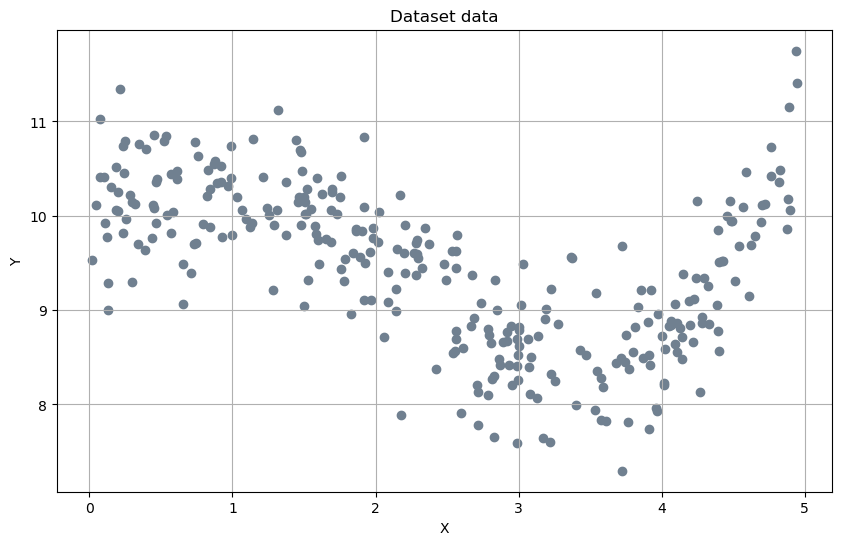

(7.297610350211348, 11.74999268743819, 9.44892101856273)

In [23]:
X = df.loc[:, df.columns != 'Y'].to_numpy()
y = df['Y'].to_numpy()

plt.figure("1", figsize=[10, 6])

plt.subplot(1,1,1)
plt.title("Dataset data")
plt.scatter(X[:, 0], y, color="slategrey")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

plt.show()
np.min(y), np.max(y), np.mean(y)

In [24]:
scores = {}
pipelines = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

for alpha in ALPHAS:
    scores[alpha] = {}

    pipelines[alpha] = Pipeline([
        ("standardizer", CustomStandardScaller(has_bias=False, apply_mean=True)),
        ("linear_model", CustomRidge(alpha=alpha))
    ])

    pipe = pipelines[alpha]
    pipe.fit(X_train, y_train)

    print("Коэффициент регуляризации:\n\ta =", alpha)
    print("Параметры модели:")
    for indx, coef in enumerate(pipe.named_steps["linear_model"].coef_):
        print(f"\tw{indx} = {coef}")

    scores[alpha]['HOLDOUT'] = run_holdout(pipe, X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
    scores[alpha]['CROSSVAL'] = run_cross_val(pipe, X, y, n_splits=SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

    for validation_type in ['HOLDOUT', 'CROSSVAL']:
        print("\nМетрики при ", end='')
        if validation_type == 'HOLDOUT':
            print("отложенной выборке (holdout)")
        else:
            print("кросс-валидации KFold")

        for set_type in [TRAIN, TEST]:
            print(f"\t{set_type} MSE = {scores[alpha][validation_type][set_type]['MSE']}")
            print(f"\t{set_type} R2 = {scores[alpha][validation_type][set_type]['R2']}")

    if alpha != ALPHAS[-1]:
        print('\n\n')

Коэффициент регуляризации:
	a = 0
Параметры модели:
	w0 = 9.434567182341345
	w1 = -1.6704407570855964
	w2 = 8.975456759220513
	w3 = 94.25682542560035
	w4 = -917.0451737381871
	w5 = 2873.0446352486183
	w6 = -3495.570625695997
	w7 = -495.61050612864864
	w8 = 3575.93488659396
	w9 = 1215.6744649430066
	w10 = -3203.9200155206563
	w11 = -3143.1720211819943
	w12 = 1471.299418929289
	w13 = 4610.7022943032325
	w14 = 873.5226928329204
	w15 = -6160.775049062213
	w16 = 2694.163805799895

Метрики при отложенной выборке (holdout)
	TRAIN MSE = 0.22052121838691024
	TRAIN R2 = 0.690311219438188
	TEST MSE = 0.23284158972090854
	TEST R2 = 0.6894647268442604

Метрики при кросс-валидации KFold
	TRAIN MSE = 0.21722338678284417
	TRAIN R2 = 0.6989842666020141
	TEST MSE = 0.24018737600391865
	TEST R2 = 0.665414113710243



Коэффициент регуляризации:
	a = 0.01
Параметры модели:
	w0 = 9.434567182340828
	w1 = 0.7965494186034026
	w2 = -2.3895213897535146
	w3 = -1.758750619963111
	w4 = 0.7195882739072492
	w5 = 1.72

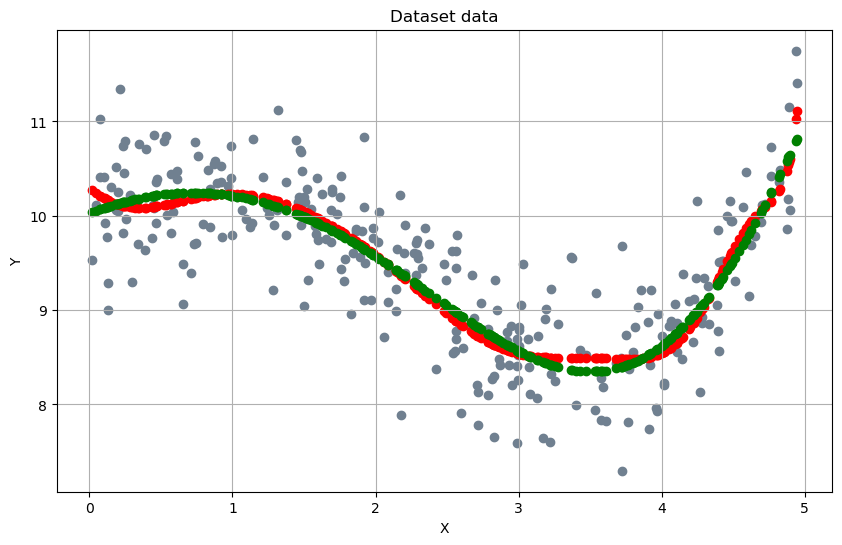

In [25]:
plt.figure("1", figsize=[10, 6])

plt.subplot(1,1,1)
plt.title("Dataset data")
plt.scatter(X[:, 0], y, color="slategrey")
plt.scatter(X[:, 0], pipelines[0].predict(X), color="red")
plt.scatter(X[:, 0], pipelines[0.01].predict(X), color="green")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

In [26]:
def plot_prediction_vs_true(title, y_train_true, y_train_pred, y_test_true, y_test_pred):
    plt.figure("17", figsize=[12, 8])
    plt.suptitle(f"{title}", fontsize=14)

    plt.subplot(2,2,1)
    plt.title("Train")
    plt.scatter(y_train_pred, y_train_true, color="slategrey")
    ylim = plt.gca().get_ylim()
    plt.plot(ylim, ylim, '--', color="grey")
    plt.xlim(ylim)
    plt.ylim(ylim)
    plt.xlabel("$\\hat{y}$")
    plt.ylabel("$y$")
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.title("Test")
    plt.scatter(y_test_pred, y_test_true, color="slategrey")
    ylim = plt.gca().get_ylim()
    plt.plot(ylim, ylim, '--', color="grey")
    plt.xlim(ylim)
    plt.ylim(ylim)
    plt.xlabel("$\\hat{y}$")
    plt.ylabel("$y$")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

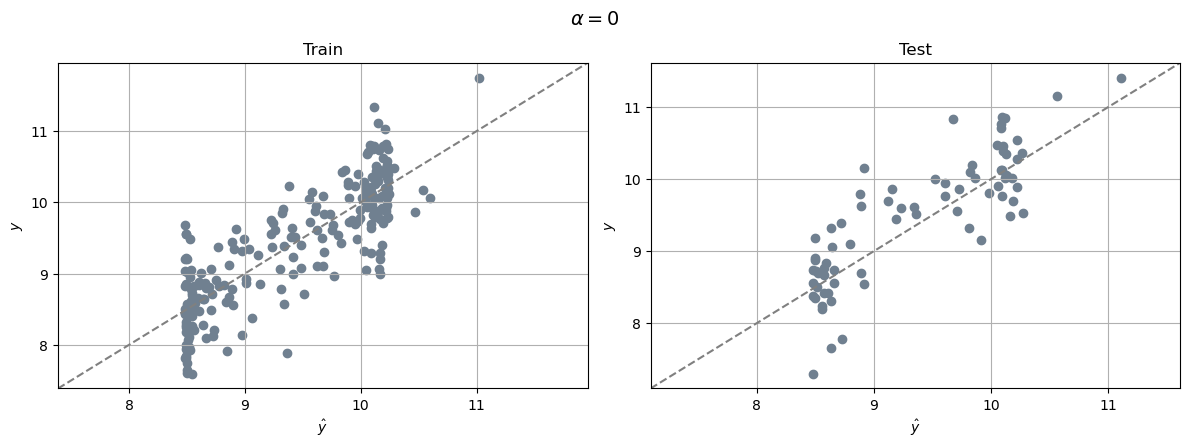

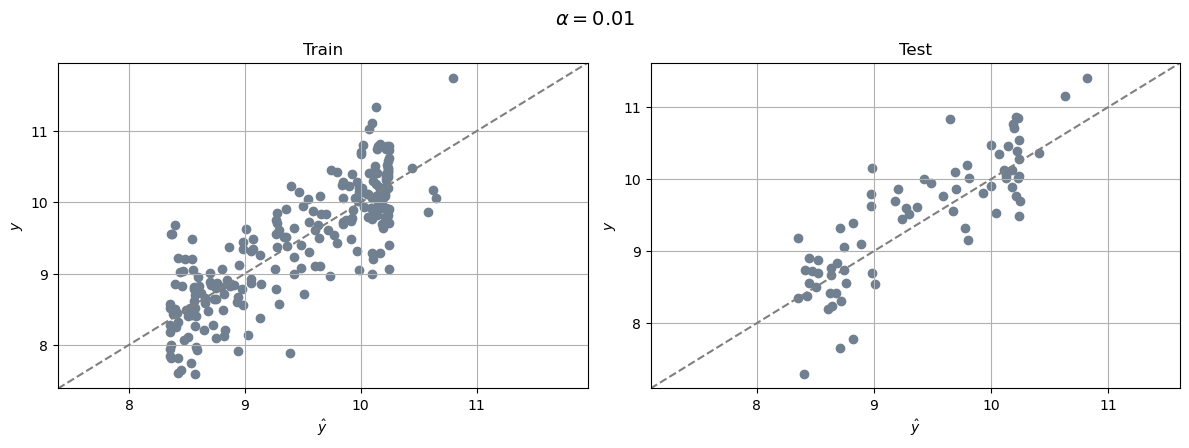

In [27]:
for alpha in ALPHAS:
    plot_prediction_vs_true(f"$\\alpha={alpha}$", y_train, pipelines[alpha].predict(X_train), y_test, pipelines[alpha].predict(X_test))